## Data Uncertainty Exercise

Created by Jenny Palomino, Lise St. Denis, and Megan Cattau for the Earth Analytics Applications Course (GEOG 5663)

## Background: 2013 Rim Fire (California)

"*The California Rim fire started on August 17th, 2013 in a remote canyon of the Stanislaus National Forest as the result of an illegal campfire. The fire was discovered when it was approximately 40 acres in size but due to drought conditions, extreme weather conditions, inaccessible terrain, and erratic winds, the fire grew to over 10,000 acres in just 36 hours and grew to over 100,000 acres in the first four days. It wasn’t declared fully contained until October 24th, 2013, reaching a final size of 257,314 acres, making it the third largest fire in California history at the time.* 

*At its peak, more than 5000 firefighting resources were assigned to the fire and it cost 127.35 million dollars to suppress (Inciweb). It resulted in 10 injuries and no fatalities. The fire threatened over five thousand structures and resulted in the evacuation of approximately X people, destroying over a hundred structures including eleven residences.*" (Lise St. Denis, Earth Lab). 

<figure>
   <a href="http://ww2.kqed.org/science/wp-content/uploads/sites/35/2014/08/Rimfiregraphic-e1408148390108.jpeg">
   <img src="http://ww2.kqed.org/science/wp-content/uploads/sites/35/2014/08/Rimfiregraphic-e1408148390108.jpeg" alt="Map of 2013 Rim Fire in California. Source: David Pierce/KQED."></a>
   <figcaption> <a href="https://www.kqed.org/science/20636/a-year-after-rim-fire-debate-sparks-over-replanting-trees" target="_blank">Source: David Pierce, KQED</a>
   </figcaption>
</figure>

## Many Available Datasets For Fire

It seems that a lot was known about the Rim Fire and its impacts. So where does that information come from?

In this Jupyter Notebook, you will learn about and explore datasets that are frequently used to study fire and ts impacts. These datasets vary in their sources as well as spatial and temporal resolutions. As you explore these data, consider the benefits and limitations are associated with each dataset. 

| Product            | Description                                                                          | Spatial             | Temporal                       |
|--------------------|--------------------------------------------------------------------------------------|---------------------|--------------------------------|
| GeoMAC Boundary    | Vector polgyon of fire perimeter                                                     | Delineated boundary | Aug 21, 2013 and Sept 26, 2013 |
| MTBS Boundary      | Vector polygon of fire perimeter; vector center point of boundary                    | Delineated boundary | 2013 (one boundary per year)   |
| MTBS Burn Severity | Raster of classes ranging from unburned-low to high severity (based on dNBR)         | 30 m cell           | 2013 (one raster per year)     |
| MODIS Active Fire  | Vector center point of MODIS burned pixels (labeled by date)                         | 1 km cell           | Daily (Aug 16, 2013 to Oct 25, 2013)                         |
| MODIS Burned Area  | Raster of MODIS burned pixels (labeled by date)                                      | 500 m cell          | Monthly (1st of the month)     |
| ICS 209 Incident Reports     | Lat/Long of ignition point; info on hazard, response, and impact throughout incident | -                   | Can be multiple per day        |


In [1]:
# Packages needed to run this notebook
import os
from datetime import datetime
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio

In [3]:
# Set working directory to downloaded california-rim-fire directory
os.chdir("/Users/shannonwhite/Downloads/california-rim-fire")

### Geospatial Multi-Agency Coordination (GeoMAC)

Data published by <a href="https://www.geomac.gov/" target="_blank">Geospatial Multi-Agency Coordination (GeoMAC)</a> are managed by the USGS. The main data provided by GeoMAC are vector boundaries of fire perimeters. These boundaries are delineated from a combination of GPS points and other data collected in the field (including hand-delineation on paper maps), and multiple boundaries can be created as an individual fire grows. 

It is important to note that spatial boundaries of fires are often drawn larger than the actual burned area (due to insufficient information about what is going on throughout the entire boundary), and thus can sometimes include unburned areas. Similarly, the vector boundary do not reflect that fire severity is not uniform within a fire boundary; rather, all areas within the fire perimeter are identified as burned area with unknown severity. 

The GeoMAC boundaries were downloaded for the <a href="https://gec.cr.usgs.gov/outgoing/GeoMAC/2013_fire_data/California/Rim/" target="_blank">Rim Fire from the GeoMAC archives</a> by selecting the first (8/21/13) and last (9/26/13) perimeters.

In [4]:
geomac_20130821_path = "GeoMAC/ca_rim_20130819_1043_dd83/ca_rim_20130819_1043_dd83.shp"
geomac_20130926_path = "GeoMAC/ca_rim_20130926_0958_dd83/ca_rim_20130926_0958_dd83.shp"

geomac_20130821 = gpd.read_file(geomac_20130821_path)
geomac_20130926 = gpd.read_file(geomac_20130926_path)

In [5]:
geomac_20130821

,UNIT_ID,FIRE_NUM,FIRE_NAME,DATE_,TIME_,COMMENTS,AGENCY,ACTIVE,FIRE,YEAR_,LOAD_DATE,INCIWEB_ID,ACRES,geometry
0,CA-STF,HV2F,Rim,2013-08-19,1043,FIMT,USFS,N,None,2013,2013-08-20,3660,10178.78,POLYGON ((-120.0818893480862 37.87209755217512...


In [6]:

geomac_20130926

,UNIT_ID,FIRE_NUM,FIRE_NAME,DATE_,TIME_,COMMENTS,AGENCY,ACTIVE,FIRE,YEAR_,LOAD_DATE,INCIWEB_ID,ACRES,geometry
0,CA-STF,HV2F,Rim,2013-09-26,0958,None,USFS,Y,None,2013,2013-09-27,3660,257135.48,(POLYGON ((-119.8871010571367 38.0479772463369...


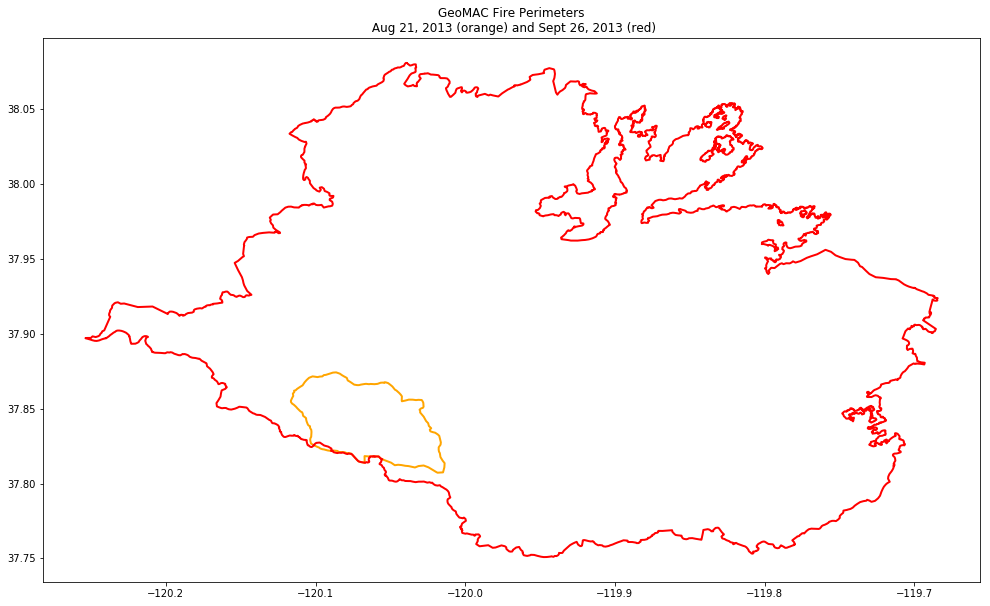

In [7]:
fig, ax1 = plt.subplots(figsize=(20, 10))

# GeoMac fire perimeter on Aug 21, 2013
geomac_20130821.plot(ax=ax1, color='None',
                       edgecolor='orange',
                       linewidth=2)

# GeoMac fire perimeter on Sept 26, 2013
geomac_20130926.plot(ax=ax1, color='None',
                       edgecolor='red',
                       linewidth=2)

ax1.set_title("GeoMAC Fire Perimeters\n Aug 21, 2013 (orange) and Sept 26, 2013 (red)",
              fontsize=12)
plt.show()

### Monitoring Trends in Burn Severity (MTBS)

<a href="https://www.mtbs.gov/" target="_blank">Monitoring Trends in Burn Severity (MTBS)</a> "is an interagency program whose goal is to consistently map the burn severity and extent of large fires across all lands of the United States from 1984 to present. This includes all fires 1000 acres or greater in the western United States and 500 acres or greater in the eastern Unites States. The extent of coverage includes the continental U.S., Alaska, Hawaii and Puerto Rico".  

MTBS provides vector boundaries of fire perimeters and rasters of burn severity at a 30 meter spatial resolution for any pixel that exists within an identified fire perimeter. 

Rasters of the burn severity are created each year (e.g. all 2013 fires in the same file), using the fire perimeters to identify areas in which to calculate the difference in normalized burn ratio (dNBR) before and after fire incidences. 

Burn severity classes are identified in the raster as follows:

| Value | Description                     |
|-------|---------------------------------|
| 0     | No data                         |
| 1     | Unburned to Low Severity        |
| 2     | Low Severity                    |
| 3     | Medium Severity                 |
| 4     | High Severity                   |
| 5     | Increased Greenness (post-fire) |
| 6     | Mask (cloud, shadow, water)     |

The MTBS data for the Rim Fire were downloaded from the <a href="https://www.mtbs.gov/direct-download" target="_blank">MTBS Direct Download</a> by selecting the 2013 data. 

In [8]:
mtbs_pt_path = "MTBS/mtbs_rim_fire_pt.shp"
mtbs_bounds_path = "MTBS/mtbs_rim_fire_bounds.shp"

mtbs_pt = gpd.read_file(mtbs_pt_path)
mtbs_bounds = gpd.read_file(mtbs_bounds_path)

In [9]:
mtbs_pt

,Fire_ID,Fire_Name,Asmnt_Type,Pre_ID,Post_ID,Fire_Type,ND_T,IG_T,Low_T,Mod_T,High_T,Ig_Date,Lat,Long,Acres,geometry
0,CA3785712008620130817,RIM,Extended,80430342013195,80430342014182,WF,-970.0,-150.0,90.0,314.0,575.0,2013-08-17,37.916,-119.969,257084.0,POINT (-119.969 37.916)


In [10]:
mtbs_bounds

,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,geometry
0,CA3785712008620130817,RIM,2013,8,17,WF,257084.0,POLYGON ((-120.1146225206582 38.03606671405372...


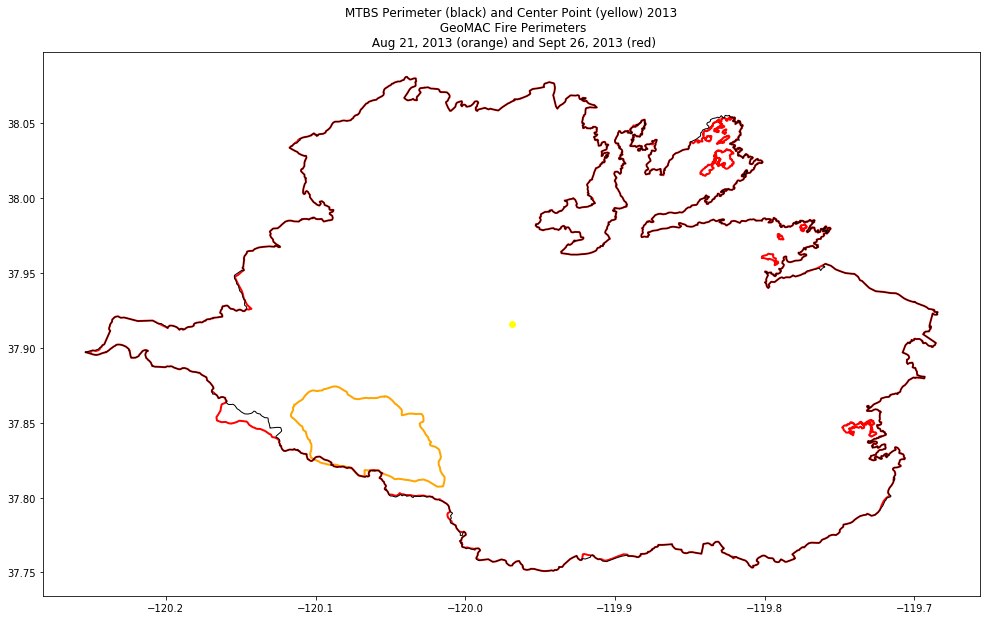

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 10))

# GeoMac fire perimeter on Aug 21, 2013
geomac_20130821.plot(ax=ax1, color='None',
                       edgecolor='orange',
                       linewidth=2)

# GeoMac fire perimeter on Sept 26, 2013
geomac_20130926.plot(ax=ax1, color='None',
                       edgecolor='red',
                       linewidth=2)

# Center point of MTBS fire boundary
mtbs_pt.plot(ax=ax1, color='yellow')

# MTBS fire boundary
mtbs_bounds.plot(ax=ax1, color='None',
                       edgecolor='black',
                       linewidth=1)

ax1.set_title("MTBS Perimeter (black) and Center Point (yellow) 2013\n GeoMAC Fire Perimeters\n Aug 21, 2013 (orange) and Sept 26, 2013 (red)",
              fontsize=12)

plt.show()

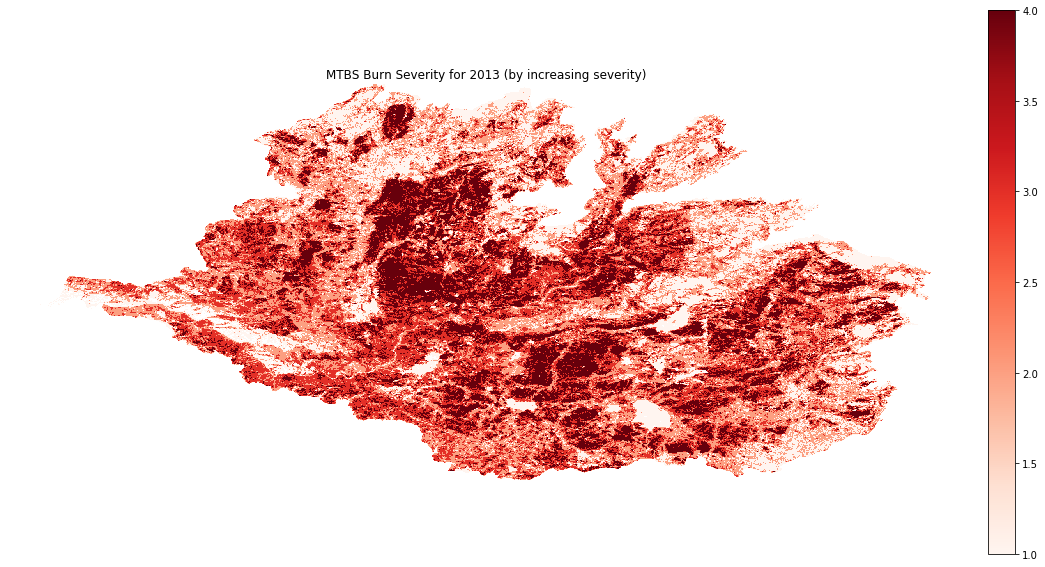

In [12]:
# MTBS burn severity raster 2013
# Display classes 1 to 4 only
with rio.open("MTBS/mtbs_rim_crop_4269.tif") as src:
    mtbs_rim_2013 = src.read()
    mtbs_rim_2013 = ma.masked_outside(mtbs_rim_2013, 1, 4)

fig, ax1 = plt.subplots(figsize=(20, 10))

im = ax1.imshow(mtbs_rim_2013[0], cmap = 'Reds')

ax1.set_title("MTBS Burn Severity for 2013 (by increasing severity)",
              fontsize=12)

ax1.axis('off')

fig.colorbar(im)

plt.show()

### MODIS Active Fire Product

MODIS Active Fire Product is the result of a workflow designed by the <a href="http://modis-fire.umd.edu/" target="_blank">University of Maryland</a> to identify fire using thermal remotely sensed images. 

The published product is composed of the vector center points of pixels from rasters collected daily for presence/absence of fire. The data represent a 1 km spatial resolution. More information is available in the  <a href="https://earthdata.nasa.gov/faq/firms-faq#ed-modis-fire-onground" target="_blank">FAQs</a> and the <a href="http://modis-fire.umd.edu/files/MODIS_C6_Fire_User_Guide_B.pdf" target="_blank">User Guide</a>. 

The MODIS Active Fire data for the Rim Fire were downloaded from  <a href="https://firms.modaps.eosdis.nasa.gov/" target="_blank">Fire Information for Resource Management System (FIRMS)</a> by searching for data between Aug 16, 2013 and Oct 25, 2013.

In [13]:
modis_active_path = "MODIS/active_fire/modis_active_rim_pts.shp"
modis_active = gpd.read_file(modis_active_path)

In [14]:
modis_active.sort_values("ACQ_DATE").head()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
2803,37.8435,-120.1033,360.2,1.8,1.3,2013-08-19,1921,Terra,MODIS,100,6.2,310.7,171.3,D,0,POINT (-120.1033 37.8435)
2842,37.8469,-120.0762,331.5,1.8,1.3,2013-08-19,1921,Terra,MODIS,61,6.2,306.0,40.8,D,0,POINT (-120.0762 37.8469)
2614,37.8409,-120.0820,312.1,1.0,1.0,2013-08-19,0956,Aqua,MODIS,84,6.2,294.1,10.7,N,0,POINT (-120.082 37.8409)
2839,37.8511,-120.0965,352.7,1.8,1.3,2013-08-19,1921,Terra,MODIS,96,6.2,309.1,124.1,D,0,POINT (-120.0965 37.8511)
2836,37.8548,-120.1141,347.0,1.8,1.3,2013-08-19,1921,Terra,MODIS,92,6.2,308.8,95.2,D,0,POINT (-120.1141 37.8548)


In [15]:
modis_active.sort_values("ACQ_DATE").tail()

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
97,38.0432,-119.8824,352.0,1.1,1.0,2013-09-20,2100,Aqua,MODIS,90,6.2,303.2,66.6,D,0,POINT (-119.8824 38.0432)
174,38.0523,-119.8917,302.6,1.5,1.2,2013-09-21,0625,Terra,MODIS,50,6.2,283.2,14.6,N,0,POINT (-119.8917 38.0523)
177,38.0538,-119.8767,304.3,1.6,1.2,2013-09-21,0625,Terra,MODIS,24,6.2,280.4,15.1,N,0,POINT (-119.8767 38.0538)
171,38.0477,-119.8236,317.1,1.6,1.2,2013-09-21,0625,Terra,MODIS,94,6.2,281.2,34.7,N,0,POINT (-119.8236 38.0477)
168,38.0461,-119.8404,307.9,1.6,1.2,2013-09-21,0625,Terra,MODIS,54,6.2,280.7,19.9,N,0,POINT (-119.8404 38.0461)


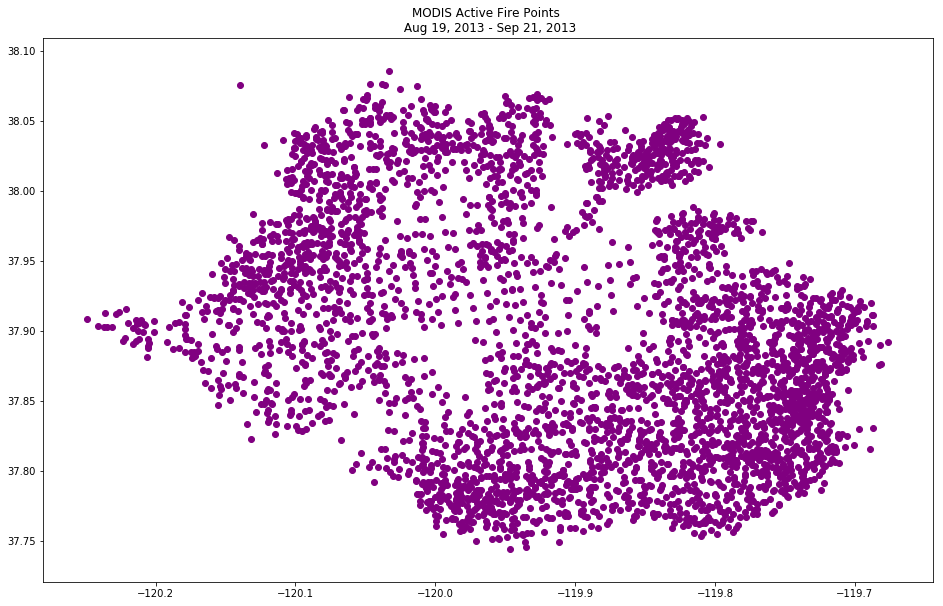

In [16]:
fig, ax1 = plt.subplots(figsize=(20, 10))

# MODIS active fire: centerpoints of pixels
modis_active.plot(ax=ax1, color='purple')

ax1.set_title("MODIS Active Fire Points \n Aug 19, 2013 - Sep 21, 2013",
              fontsize=12)

plt.show()

In [17]:
# Calculate day of year from acquisition date
modis_active['ACQ_DATE'] = pd.to_datetime(modis_active["ACQ_DATE"])
modis_active['DOY'] = modis_active['ACQ_DATE'].dt.dayofyear

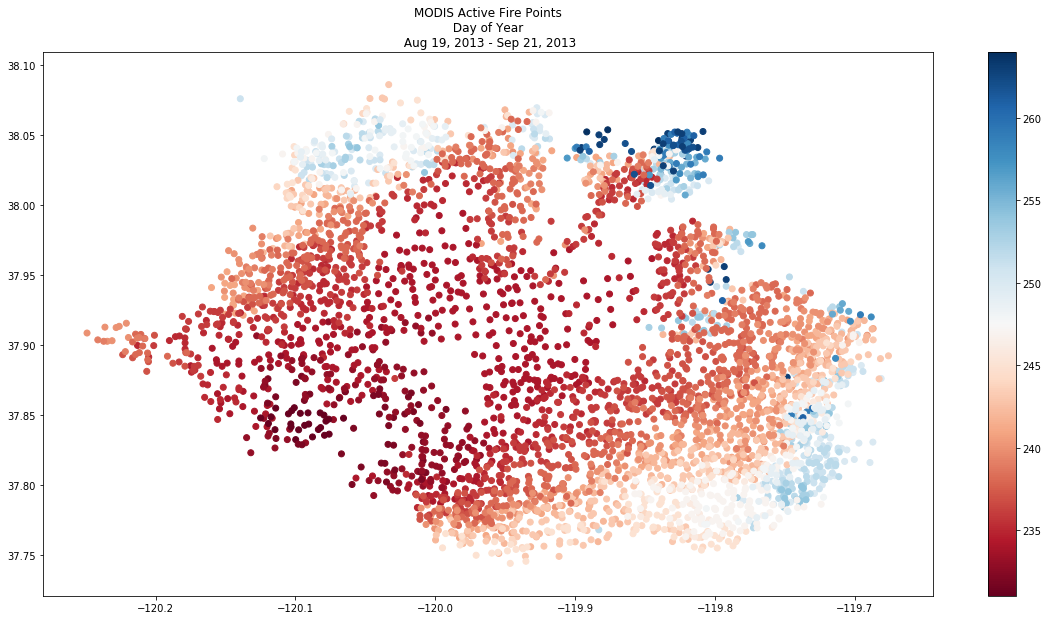

In [18]:
fig, ax1 = plt.subplots(figsize=(20, 10))

# MODIS active fire points by day of year value 
modis_active.plot(ax=ax1, column = "DOY", cmap='RdBu', legend = True)

ax1.set_title("MODIS Active Fire Points\n Day of Year \n Aug 19, 2013 - Sep 21, 2013",
              fontsize=12)

plt.show()

### MODIS Burned Area Product

MODIS Burned Area is another product that has resulted a workflow designed by the <a href="http://modis-fire.umd.edu/" target="_blank">University of Maryland</a> to identify fire using remotely sensed images. The data are not dependent on a known fire perimeter but are calculated through the use of vegetation and burn indices. 

The published product is a set of rasters (with a 500 meter spatial resolution) that is released on the first of the each month. The set includes rasters that label the first and last day of fire in the pixel for that month as well as rasters that provide a measure of uncertainty regarding the dates. More information is available in the <a href="https://cdn.earthdata.nasa.gov/conduit/upload/908/MODIS_Burned_Area_Collection51_User_Guide_3.0.pdf" target="_blank">User Guide</a>. 

The MODIS Burned Area data for the Rim Fire were downloaded from  <a href="https://ladsweb.modaps.eosdis.nasa.gov/search/order/1" target="_blank">Level-1 and Atmosphere Archive & Distribution System Distributed Active Archive Center (LAADS DAAC)</a> by searching for data between Aug 1, 2013 and Nov 1, 2013.

In [19]:
with rio.open("MODIS/burned_area/modis_ba_20130101_firstday_4269_rimfire.tif") as src:
    modis_ba = src.read()
    modis_ba_firstday = ma.masked_where(
        modis_ba <=0, modis_ba)

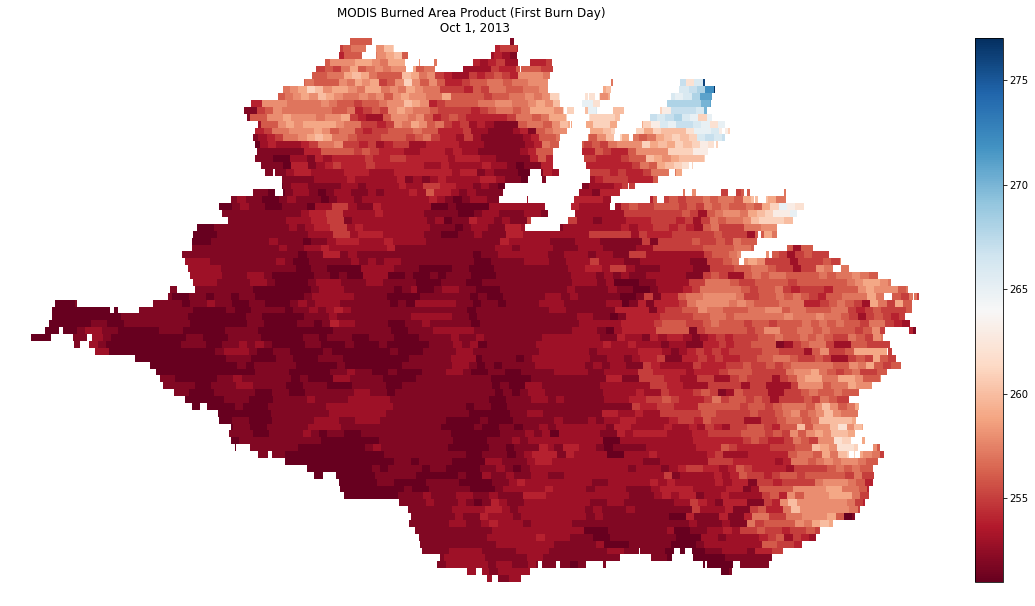

In [20]:
fig, ax1 = plt.subplots(figsize=(20, 10))

# MODIS Burned Area Product: First Day of Burn
im = ax1.imshow(modis_ba_firstday[0], cmap = 'RdBu', aspect = 'auto')

ax1.set_title("MODIS Burned Area Product (First Burn Day) \n Oct 1, 2013",
              fontsize=12)

fig.colorbar(im)

ax1.axis('off')

plt.show()

### Incident Status Summary (ICS 209) Report

The <a href="https://famit.nwcg.gov/applications/SIT209" target="_blank">Incident Status Summary (ICS 209)</a> reports are snapshots that are created by the agency that is tasked with the incidence response. They represent what is known "in the moment" for the physical hazard (e.g. total burned area), the incident response (e.g. deployed personnel), and the impact (e.g. buildings threatened or damaged, fatalities). These reports are published daily (or more frequently) as a wildfire incident progresses. 

This data is publicly available but not very usable; thus, coming up with an easy and reproducible method to analyze this data in real-time is very important. This is the goal of Lise St. Denis (Earth Lab) and her team. 

The ICS 209 reports for the 2013 Rim Fire have been aggregated and summarized below. 

In [21]:
ics_209_rim_fire = pd.read_csv("ICS-209/rimSitreps.csv", 
                               parse_dates = ["REPORT_TO_DATE"])

ics_209_rim_fire.head()

,Unnamed: 0,POO_LATITUDE,POO_LONGITUDE,DISCOVERY_DOY,DISCOVERY_DATE,REPORT_TO_DATE,REPORT_DOY,STR_THREATENED,STR_DAMAGED,STR_DESTROYED,...,TOTAL_PERSONNEL,ACRES,NEW_ACRES,EST_IM_COST_TO_DATE,EVACUATION_IN_PROGRESS,WEATHER_CONCERNS_NARR,WF_FSR,PCT_FINAL_SIZE,PCT_GROWTH_REL_FINAL,CURRENT_THREAT_NARR
0,109728,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-08-17 22:00:00,229,NaN,NaN,NaN,...,0.0,200.0,200.0,40000.0,False,Current Weather RH: 14 TEMP: 95 WS: 6-12 WD: S...,200.0,0.000777,0.000777,wild and scenic river. powerlines and infrastr...
1,109729,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-08-18 11:45:00,230,NaN,NaN,NaN,...,0.0,250.0,50.0,80000.0,False,Current Weather RH: 31 TEMP: 72 WS: 6 WD: 063 ...,50.0,0.000972,0.000194,wild and scenic tuolumne river
2,109730,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-08-18 17:30:00,230,NaN,NaN,NaN,...,252.0,450.0,200.0,475000.0,False,Current Weather RH: 11 TEMP: 97 WS: 22 WD: Wes...,200.0,0.001749,0.000777,wild and scenic tuolumne river
3,109731,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-08-18 18:00:00,230,NaN,NaN,NaN,...,252.0,450.0,0.0,475000.0,False,Current Weather RH: 11 TEMP: 97 WS: 22 WD: Wes...,0.0,0.001749,0.000000,wild and scenic tuolumne river
4,109732,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-08-19 06:00:00,231,NaN,NaN,NaN,...,166.0,800.0,350.0,600000.0,False,Current Weather RH: 58-73 TEMP: 62-69 WS: 4-8 ...,350.0,0.003109,0.001360,natural resources: water quality and sediment ...


In [22]:
ics_209_rim_fire.tail()

,Unnamed: 0,POO_LATITUDE,POO_LONGITUDE,DISCOVERY_DOY,DISCOVERY_DATE,REPORT_TO_DATE,REPORT_DOY,STR_THREATENED,STR_DAMAGED,STR_DESTROYED,...,TOTAL_PERSONNEL,ACRES,NEW_ACRES,EST_IM_COST_TO_DATE,EVACUATION_IN_PROGRESS,WEATHER_CONCERNS_NARR,WF_FSR,PCT_FINAL_SIZE,PCT_GROWTH_REL_FINAL,CURRENT_THREAT_NARR
95,109823,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-10-04 18:00:00,277,0.0,7.0,112.0,...,139.0,257135.0,0.0,127200000.0,False,NaN,0.000000,0.999304,0.000000,commercial recreation along the tuolumne and c...
96,109824,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-10-10 15:30:00,283,0.0,7.0,112.0,...,128.0,257171.0,36.0,127250000.0,False,NaN,6.000000,0.999444,0.000140,commercial recreational along the tuolumne and...
97,109825,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-10-17 14:30:00,290,0.0,7.0,112.0,...,42.0,257171.0,0.0,127345000.0,False,NaN,0.000000,0.999444,0.000000,commercial recreational along the tuolumne and...
98,109826,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-10-18 13:00:00,291,0.0,7.0,112.0,...,42.0,257171.0,0.0,127345000.0,False,NaN,0.000000,0.999444,0.000000,commercial recreational along the tuolumne and...
99,109827,37.857222,-120.086389,229.0,2013-08-17 15:25:00,2013-10-24 18:00:00,297,0.0,7.0,112.0,...,42.0,257314.0,143.0,127350000.0,False,NaN,23.833333,1.000000,0.000556,NaN


### Example Plots Created from ICS 209 Report

<img src="http://drive.google.com/uc?export=view&id=1_oYSYszC09MwzG4LJN0b20ydm7SHa2me">

## Group Discussion: Benefits and Limitations of Datasets


### GeoMAC Fire Perimeter (vector polygons)

#### Benefits


#### Limitations 
 


### MTBS Burn Severity (yearly raster)

#### Benefits


#### Limitations 



### MODIS Active Fire Product (daily vector points)

#### Benefits


#### Limitations 



### MODIS Burned Area Product (monthly raster)

#### Benefits


#### Limitations 



### ICS 209 Report (daily reports)


#### Benefits


#### Limitations 



## Can We Combine Datasets To Complete The Story?

## Using GIS and Remote Sensing Data Together

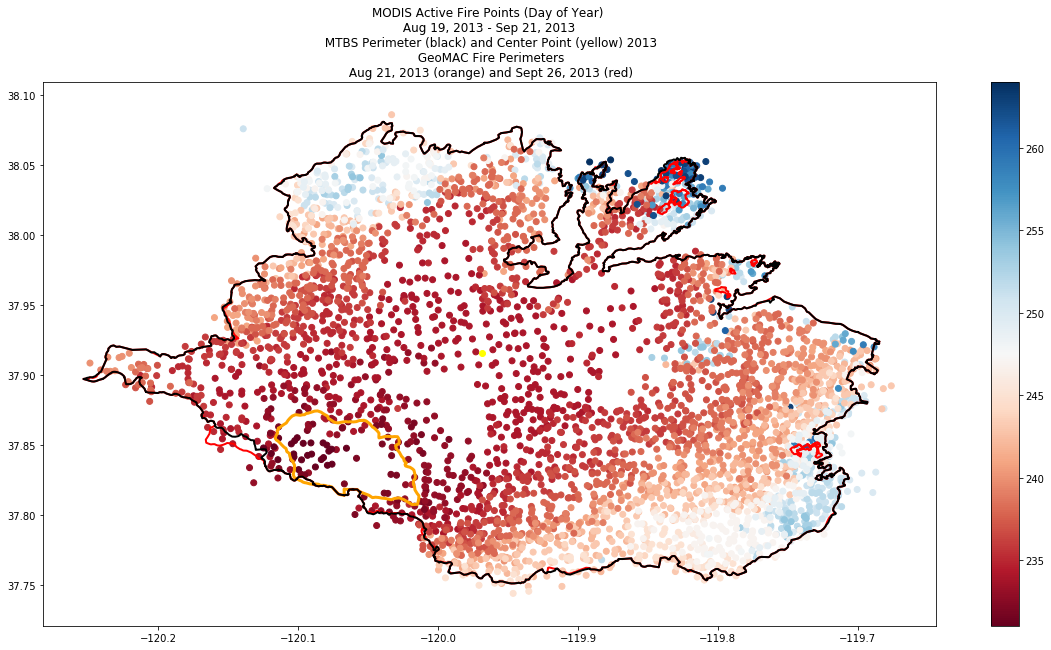

In [23]:
fig, ax1 = plt.subplots(figsize=(20, 10))

# MODIS active fire points by day of year value 
modis_active.plot(ax=ax1, column = "DOY", cmap='RdBu', legend = True)

# GeoMac fire perimeter on Aug 21, 2013
geomac_20130821.plot(ax=ax1, color='None',
                       edgecolor='orange',
                       linewidth=3)

# GeoMac fire perimeter on Sept 26, 2013
geomac_20130926.plot(ax=ax1, color='None',
                       edgecolor='red',
                       linewidth=2)

# Center point of MTBS fire boundary
mtbs_pt.plot(ax=ax1, color='yellow')

# MTBS fire boundary
mtbs_bounds.plot(ax=ax1, color='None',
                       edgecolor='black',
                       linewidth=2)

ax1.set_title("MODIS Active Fire Points (Day of Year) \n Aug 19, 2013 - Sep 21, 2013 \n MTBS Perimeter (black) and Center Point (yellow) 2013\n GeoMAC Fire Perimeters\n Aug 21, 2013 (orange) and Sept 26, 2013 (red)",
              fontsize=12)

plt.show()

## Combining ICS 209 With GIS Data

* MTBS Fire Boundary (black line)
* Burn Progression (Calculated from ICS 209 data)
* ICS 209 Ignition Point (black point)
* ICS 209 Report (plots of time series)

<figure>
   <a href="http://drive.google.com/uc?export=view&id=1zCGlADEHorNkbp5af6ysXfcDuVK_Bjmx">
   <img src="http://drive.google.com/uc?export=view&id=1zCGlADEHorNkbp5af6ysXfcDuVK_Bjmx" alt="Combined Map of Multiple Datasets for 2013 Rim Fire in California. Source: Lise St. Denis, Earth Lab."></a>
   <figcaption> Source: Lise St. Denis, Earth Lab
   </figcaption>
</figure>

## Leveraging Time Series Data

This figure shows the progression of the Wallow Fire in Arizona based on perimeter data collected from the GeoMAC database, spanning May 30, 2011 to June 27, 2011. The perimeter at the end of May is outlined in white, with brighter colors indicating later dates. 

The plots show daily local meteorological conditions and monthly regional mean conditions for the Wallow Fire, along with the associated burned area over time. The blue line represents monthly averages of meteorological quantities computed over the entire Arizona/New Mexico Mountains ecoregion, and black points represent values extracted for "local" 4 km grid cells contained within the final burned area perimeter of the Wallow Fire. 

More information available in <a href="https://www.biorxiv.org/content/10.1101/384115v3" target="_blank">this publication by Earth Lab</a>.

<figure>
   <a href="http://drive.google.com/uc?export=view&id=16E4EJ0CNn3MjXVBYLFn5yBQtFH2Lrc6z">
   <img src="http://drive.google.com/uc?export=view&id=16E4EJ0CNn3MjXVBYLFn5yBQtFH2Lrc6z" alt="Combined Map of Multiple Datasets for 2013 Rim Fire in California. Source: Lise St. Denis, Earth Lab."></a>
   <figcaption> Source: Earth Lab
   </figcaption>
</figure>

## Assignment for March 1st, 2019 by noon

This submission consists of a written response to the following questions (2-3 sentences on each), in regard to your project:

1. How do the raw data used in your project introduce uncertainty regarding the environmental or societal process that is being studied (e.g. representation of the process, spatial/temporal resolution or extent of the raw data, too much or too little data)?
2. How do your processing steps (e.g. coordinate systems, chosen resolution or extent of analysis, methods) introduce data uncertainty into your workflow?
3. How do your desired output products (e.g. classification definitions, formats, time steps represented) introduce data uncertainty into your workflow?
4. How can you address data uncertainty in your project (e.g. integrating other data sources, using specific methods to address or quantify uncertainty in your field, conducting multiple analyses across various resolutions and extents)?  Note: if this is a difficult question to answer, seek additional guidance from your project mentor or instructor.

You may submit directly to the text entry on CANVAS or you may upload a word document or provide a link to to a shared document (e.g. google docs). More details available on CANVAS.